# Compare Training

Copyright 2019 IBM Corp.

# Load Processed Data

* This data is created by running the notebook prepare-data.ipynb

In [1]:
import pickle, os

home_dir = "../data"
processed_data_pkl = os.path.join(home_dir, "processed_data.pkl")

with open(processed_data_pkl, 'rb') as f:
    data_df, exclude_features, analytics = pickle.load( f)

print(data_df.shape)
data_df.head(4)

(1301293, 200)


,loan_amnt,term,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,pymnt_plan,recoveries,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,emp_title,title,zip_code
100,30000.0,0.0,5.0,100000.0,30.46,0.0,0.0,11.0,1.0,15603.0,...,n,0.0,30026.442500,30026.44,26.44,0.0,30000.0,Supervisor,Debt consolidation,917xx
152,40000.0,1.0,1.0,45000.0,50.53,0.0,0.0,18.0,0.0,34971.0,...,n,0.0,40856.678960,40856.68,856.68,0.0,40000.0,Assistant to the Treasurer (Payroll),Credit card refinancing,456xx
170,20000.0,0.0,10.0,100000.0,18.92,0.0,0.0,9.0,0.0,25416.0,...,n,0.0,20215.792430,20215.79,215.79,0.0,20000.0,Teacher,Credit card refinancing,982xx
186,4500.0,0.0,10.0,38500.0,4.64,0.0,0.0,12.0,0.0,4472.0,...,n,0.0,4549.217149,4549.22,49.22,0.0,4500.0,Accounts Examiner III,Credit card refinancing,786xx


In [2]:
import pandas as pd
import numpy as np
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline

In [3]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 20, 10
rcParams['font.size'] = 22

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
def print_score(clf, X_train, y_train, X_test, y_test, train=False):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))    

In [5]:
def train_and_score(data_train, data_test, features, target, score=False, plot_features=False):
    
    print("Extracting train and test data")
    
    X_train = data_train[features]
    y_train = data_train[target]
    
    print('\tX_train shape: {} \t y_train shape: {}'.format(X_train.shape, y_train.shape))

    X_test = data_test[features]
    y_test = data_test[target]
    
    print('\tX_test  shape: {} \t y_test  shape: {}'.format(X_test.shape, y_test.shape))

    # Train Loan Acceptance classifier
    print("Training classifier")
    acceptance_classifier = RandomForestClassifier(n_estimators=40, random_state=21, class_weight=None)
    out = acceptance_classifier.fit(X_train, y_train)
    print(out)
    
    if score:
        print_score(acceptance_classifier, 
                X_train, y_train, 
                X_test,  y_test , train=False)

    if plot_features:
        # Get top features
        feature_importances = pd.DataFrame(acceptance_classifier.feature_importances_, 
                                   index = features,
                                   columns=['importance']).\
                                   sort_values('importance',ascending=False)
        # Plot
        feature_importances.iloc[:10,:].plot(kind='barh')
        plt.show()
    
    return acceptance_classifier

In [6]:
def calc_threshold(X, gain_col, plot=False):

    thrs = [0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
            0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
            0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
            0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 ]

    gain = np.array([X.loc[X.score <= thr, gain_col].sum()  for thr in thrs])

    if plot:
        plt.plot(thrs, gain)
        plt.xlabel('Threshold')
        plt.ylabel(gain_col)
        plt.show()

  
    b = np.argmax(gain)
    optimal_threshold = thrs[b]
    
    return optimal_threshold

In [7]:
def evaluate_invest(sample_df, invest_sum, optimal_threshold, plot=False ):
    
    eval_fields = [gain_col, 'loan_amnt', 'LoanStatus', 'recoveries', 'total_rec_prncp', 'total_rec_int']

    # Apply the selection rule
    selected_df = sample_df.loc[sample_df.score <= optimal_threshold, eval_fields]

    # Buy the loans up to the investment sum
    invested_df = selected_df.loc[selected_df['loan_amnt'].cumsum() <= invest_sum, :]

    # Calculate the return, amount invested, loss, gain
    invested_return = invested_df[gain_col] / invested_df['loan_amnt']
    invested_amnt = invested_df['loan_amnt'].sum()
    invested_loss = invested_df['loan_amnt'].sum() \
                    - invested_df['total_rec_prncp'].sum() - invested_df['recoveries'].sum()
    invested_int  = invested_df['total_rec_int'].sum()
    invested_loss = max(invested_loss, 0)
    invested_gain = invested_df[gain_col].sum()
    return_on_investment = 100 * invested_gain / invested_amnt
    
    # Collect some loan statistics
    num_loans = invested_df.shape[0]
    num_failed = invested_df.loc[invested_df['LoanStatus'] > 0, 'LoanStatus'].count()
    
    

    # figure size in inches
    rcParams['figure.figsize'] = 20,10
    rcParams['font.size'] = 22
       
    print("\tInvested ${0:,.2f}".format(invested_amnt))
    print("\tReturn    {0:.4f}%".format(return_on_investment))
    print("\t\tNumber loans:  {0:}".format(num_loans))
    print("\t\tNumber failed: {0:}".format(num_failed))
    print("\t\tInterest paid:      ${0:15,.2f}".format(invested_int))
    print("\t\tLoss of principal:  ${0:15,.2f}".format(invested_loss))
    print("\t\tTotal gain:         ${0:15,.2f}".format(invested_gain))
    
    if plot:
        invested_return.hist(bins=150)
        plt.show()
    return invested_amnt, num_loans, num_failed, invested_loss, invested_gain, return_on_investment

# Generate train, test, and validate sets

In [8]:
# split validate set
v_size = 0.2
idx, idx_validate = \
            train_test_split(data_df.index, test_size=v_size, random_state=101)

# split train / test sets
test_size = 0.15
idx_train, idx_test = \
            train_test_split(idx, test_size=test_size)

# Define train, test, and validate df
train_df    = data_df.loc[idx_train, :]
test_df     = data_df.loc[idx_test, :]
validate_df = data_df.loc[idx_validate, :]

print("Number of loans in Train    set: {}".format(train_df.shape[0]))
print("Number of loans in Test     set: {}".format(test_df.shape[0]))
print("Number of loans in Validate set: {}".format(validate_df.shape[0]))

Number of loans in Train    set: 884878
Number of loans in Test     set: 156156
Number of loans in Validate set: 260259


# Train various classifiers

## (1) Base case: All features, with no data balancing

In [9]:
# define all features
all_features = [col for col in data_df.columns if col not in exclude_features and col not in analytics]
print(all_features)

['loan_amnt', 'term', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'disbursement_

Extracting train and test data
	X_train shape: (884878, 166) 	 y_train shape: (884878,)
	X_test  shape: (156156, 166) 	 y_test  shape: (156156,)
Training classifier
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=21, verbose=0, warm_start=False)
Test Result:

accuracy score: 0.8017

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.81      0.99      0.89    124922
         1.0       0.54      0.06      0.10     31234

   micro avg       0.80      0.80      0.80    156156
   macro avg       0.67      0.52      0.49    156156
weighted avg       0.75      0.80      0.73    156156


Confusion Matrix: 
 [[123469   145

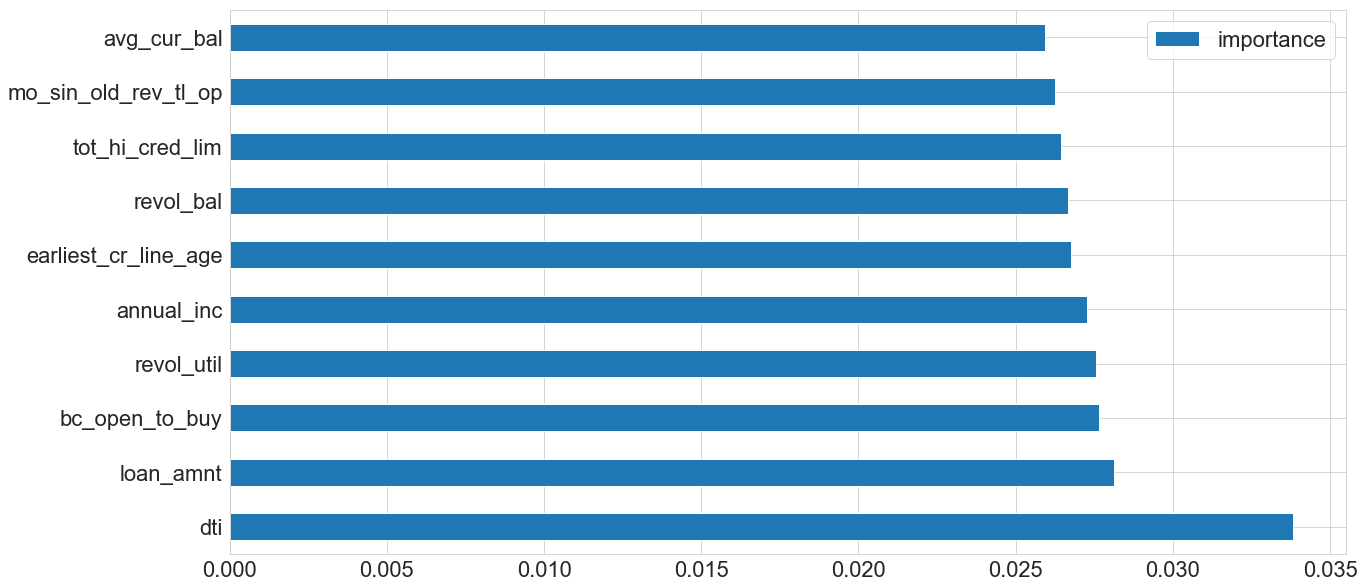

In [10]:
# Set optional arguments
options = {
    'score':         True, 
    'plot_features': True
}

# Train classifier with all features
clf_all = train_and_score(train_df, test_df, all_features, 'LoanStatus', **options )

## (2) Balance the training data; train on all features

In [11]:
# balance train data
idx_balanced = train_df.drop(train_df[train_df['LoanStatus'] < 1.0].sample(frac=.75).index).index

# define the balanced train dataframe
balanced_df = data_df.loc[idx_balanced, :]

# Print the counts
print(balanced_df['LoanStatus'].value_counts())

0.0    177112
1.0    176432
Name: LoanStatus, dtype: int64


Extracting train and test data
	X_train shape: (353544, 166) 	 y_train shape: (353544,)
	X_test  shape: (156156, 166) 	 y_test  shape: (156156,)
Training classifier
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=21, verbose=0, warm_start=False)
Test Result:

accuracy score: 0.6542

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.88      0.66      0.75    124922
         1.0       0.32      0.63      0.42     31234

   micro avg       0.65      0.65      0.65    156156
   macro avg       0.60      0.64      0.59    156156
weighted avg       0.76      0.65      0.69    156156


Confusion Matrix: 
 [[82630 42292]

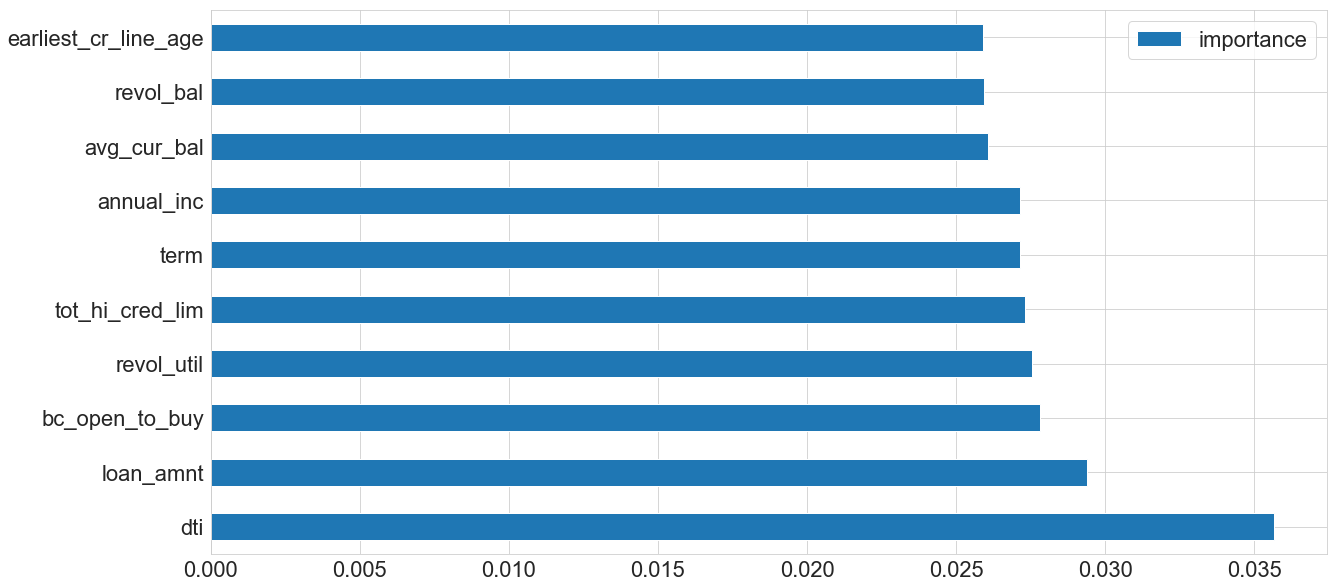

In [12]:
# Set optional arguments
options = {
    'score':         True, 
    'plot_features': True
}

# Train classifier with all features
clf_bal = train_and_score(balanced_df, test_df, all_features, 'LoanStatus', **options )

## (3) Use core features

In [13]:
# define core features

optional_features = [ 
    'acc_now_delinq', 'acc_open_past_24mths', 'application_type', 'avg_cur_bal',
    'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
    'collections_12_mths_ex_med', 
    'disbursement_method',
    'delinq_2yrs', 'delinq_amnt',   
    'initial_list_status',
    'inq_last_6mths',  'mort_acc', 
    'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
    'mths_since_recent_bc', 'mths_since_recent_inq',
    'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 
    'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
    'num_accts_ever_120_pd','num_actv_bc_tl', 'num_actv_rev_tl',
    'open_acc', 
    'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'policy_code', 'pub_rec',  'pub_rec_bankruptcies', 
    'revol_bal', 'revol_util',
    'tax_liens',
    'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort',
    'total_bc_limit', 'total_il_high_credit_limit',  'total_rev_hi_lim'
]

core_features = [col for col in all_features if col not in optional_features]

print(core_features)

['loan_amnt', 'term', 'emp_length', 'annual_inc', 'dti', 'earliest_cr_line_age', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improv

Extracting train and test data
	X_train shape: (353544, 115) 	 y_train shape: (353544,)
	X_test  shape: (156156, 115) 	 y_test  shape: (156156,)
Training classifier
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=21, verbose=0, warm_start=False)
Test Result:

accuracy score: 0.6382

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.87      0.64      0.74    124922
         1.0       0.30      0.63      0.41     31234

   micro avg       0.64      0.64      0.64    156156
   macro avg       0.59      0.63      0.57    156156
weighted avg       0.76      0.64      0.67    156156


Confusion Matrix: 
 [[80100 44822]

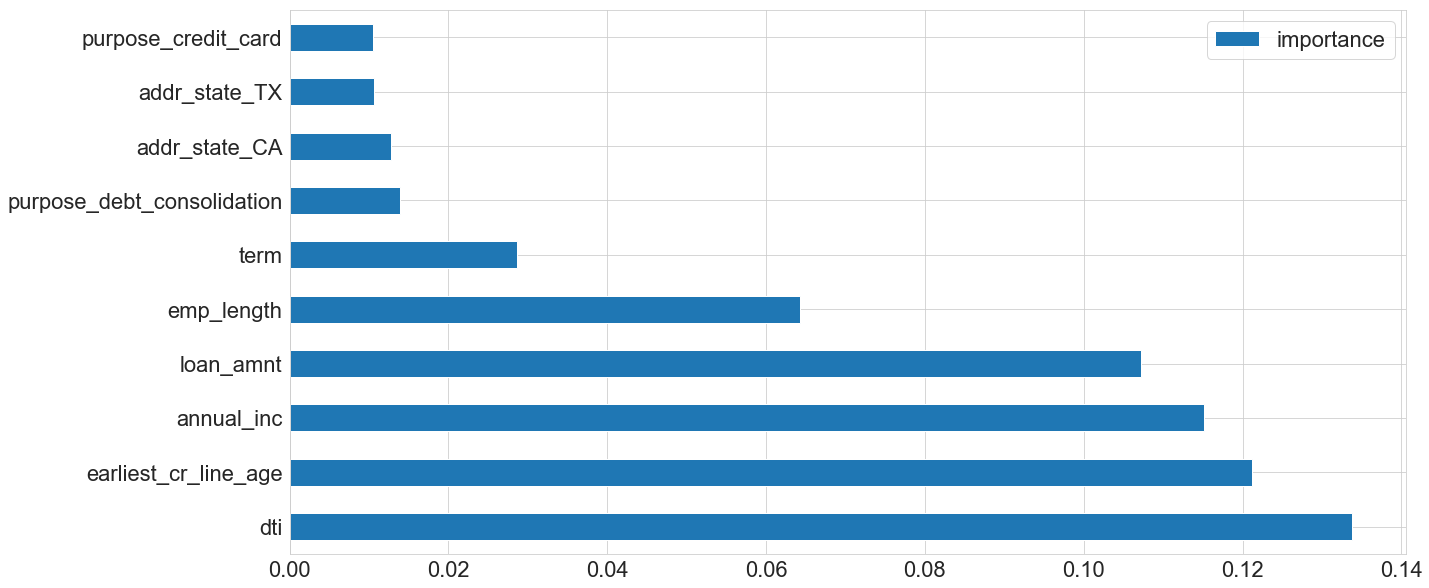

In [14]:
# Set optional arguments
options = {
    'score':         True, 
    'plot_features': True
}


# Train classifier with balanced core features
clf_core = train_and_score(balanced_df, test_df, core_features, 'LoanStatus', **options )

## (4) Minimal features

In [15]:
# define minimal features

minimal_features = [col for col in core_features if col.find("grade") < 0 and col.find("addr") < 0]
print(minimal_features)

['loan_amnt', 'term', 'emp_length', 'annual_inc', 'dti', 'earliest_cr_line_age', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding']


Extracting train and test data
	X_train shape: (353544, 29) 	 y_train shape: (353544,)
	X_test  shape: (156156, 29) 	 y_test  shape: (156156,)
Training classifier
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=21, verbose=0, warm_start=False)
Test Result:

accuracy score: 0.6180

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.86      0.63      0.72    124922
         1.0       0.28      0.57      0.38     31234

   micro avg       0.62      0.62      0.62    156156
   macro avg       0.57      0.60      0.55    156156
weighted avg       0.74      0.62      0.65    156156


Confusion Matrix: 
 [[78601 46321]
 

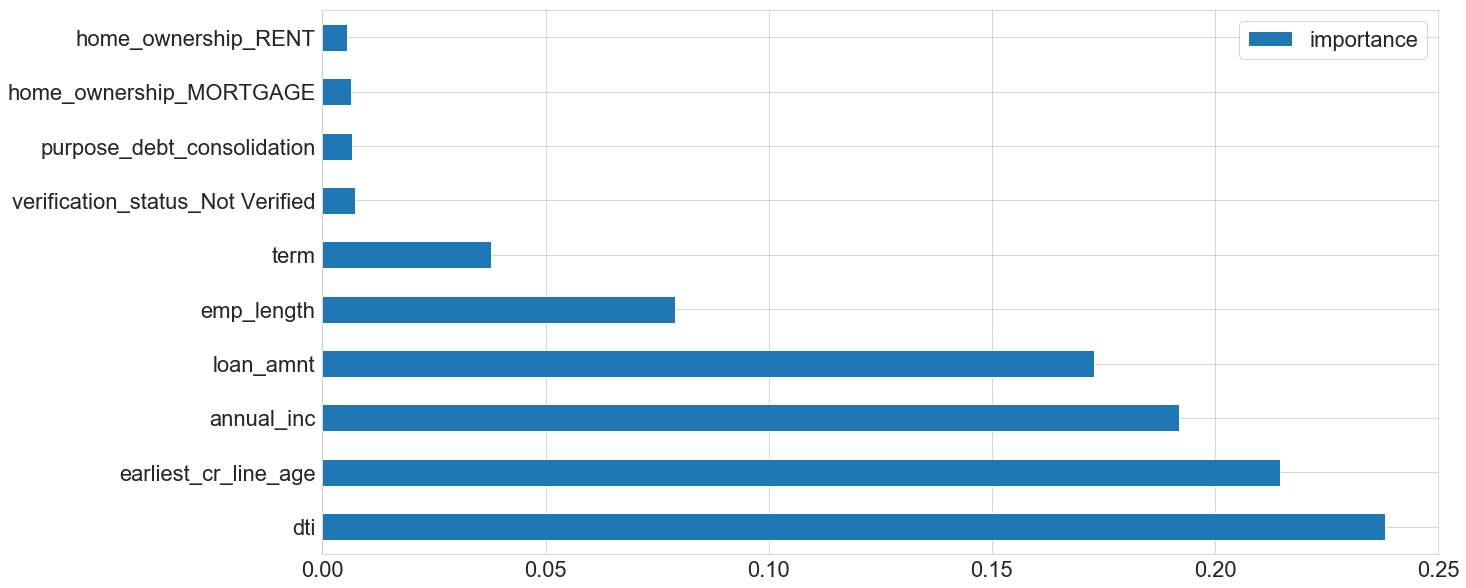

In [16]:
# Train classifier with balanced data and core features
clf_minimal = train_and_score(balanced_df, test_df, minimal_features, 'LoanStatus', **options )

# Evaluation

In [17]:
# Create dictionary
eval_dict = {
    'all features, unbalanced':   {'clf': clf_all,     'features': all_features,     'threshold': None},
    'all features, balanced':     {'clf': clf_bal,     'features': all_features,     'threshold': None},
    'core features, balanced':    {'clf': clf_core,    'features': core_features,    'threshold': None},
    'minimal features, balanced': {'clf': clf_minimal, 'features': minimal_features, 'threshold': None}
}

## Calculate optimal thresholds

In [18]:
# select criterion
gain_col = 'TotalGain'

# calculate thresholds
for key, val in eval_dict.items():
    clf       = val['clf']
    features  = val['features']
    
    test_df['score'] = clf.predict_proba(test_df[features])[:,1]    
    val['threshold'] = calc_threshold(test_df, gain_col)
    
    print("For predictor with {0:}, the threshold is {1:.4f}".format(key, val['threshold']))

For predictor with all features, unbalanced, the threshold is 0.3000
For predictor with all features, balanced, the threshold is 0.5750
For predictor with core features, balanced, the threshold is 0.6250
For predictor with minimal features, balanced, the threshold is 0.6250


## Evaluate


Using predictor all features, unbalanced
	Invested $99,991,725.00
	Return    5.2540%
		Number loans:  7257
		Number failed: 1102
		Interest paid:      $  15,028,111.34
		Loss of principal:  $   9,686,460.32
		Total gain:         $   5,253,539.80


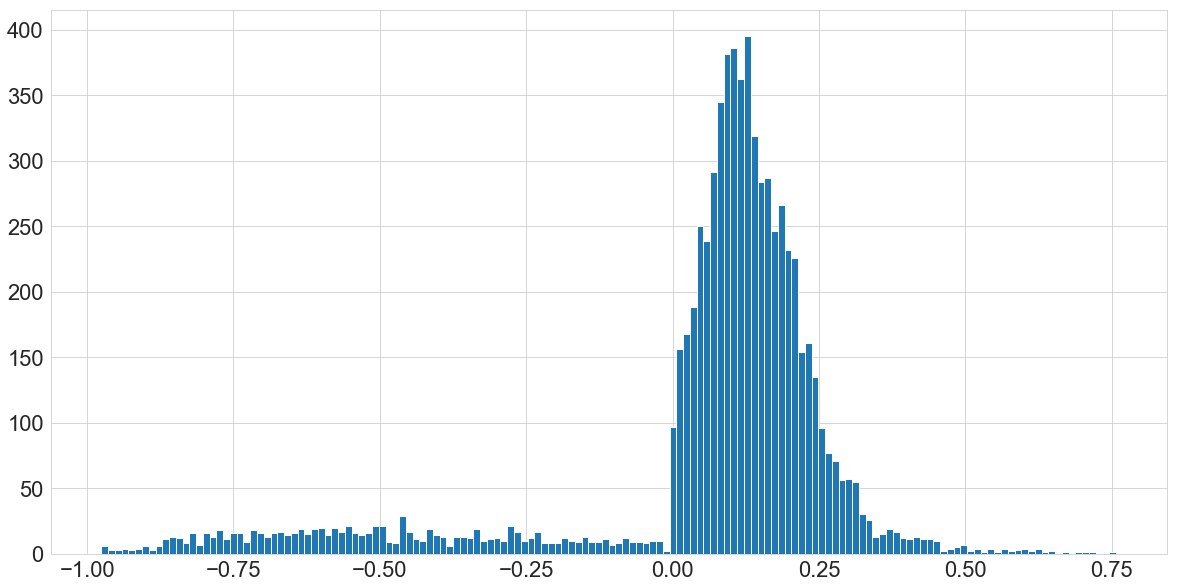


Using predictor all features, balanced
	Invested $99,974,550.00
	Return    5.0182%
		Number loans:  7273
		Number failed: 1078
		Interest paid:      $  14,556,141.26
		Loss of principal:  $   9,463,384.65
		Total gain:         $   5,016,873.39


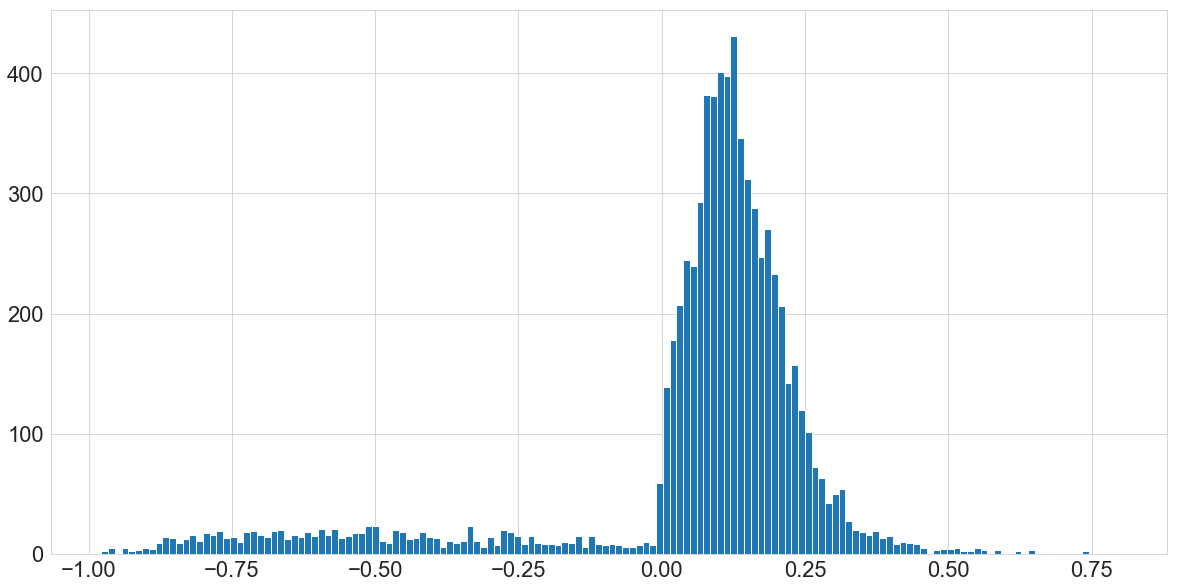


Using predictor core features, balanced
	Invested $99,990,925.00
	Return    4.2509%
		Number loans:  7327
		Number failed: 1140
		Interest paid:      $  14,487,363.09
		Loss of principal:  $  10,126,998.20
		Total gain:         $   4,250,527.76


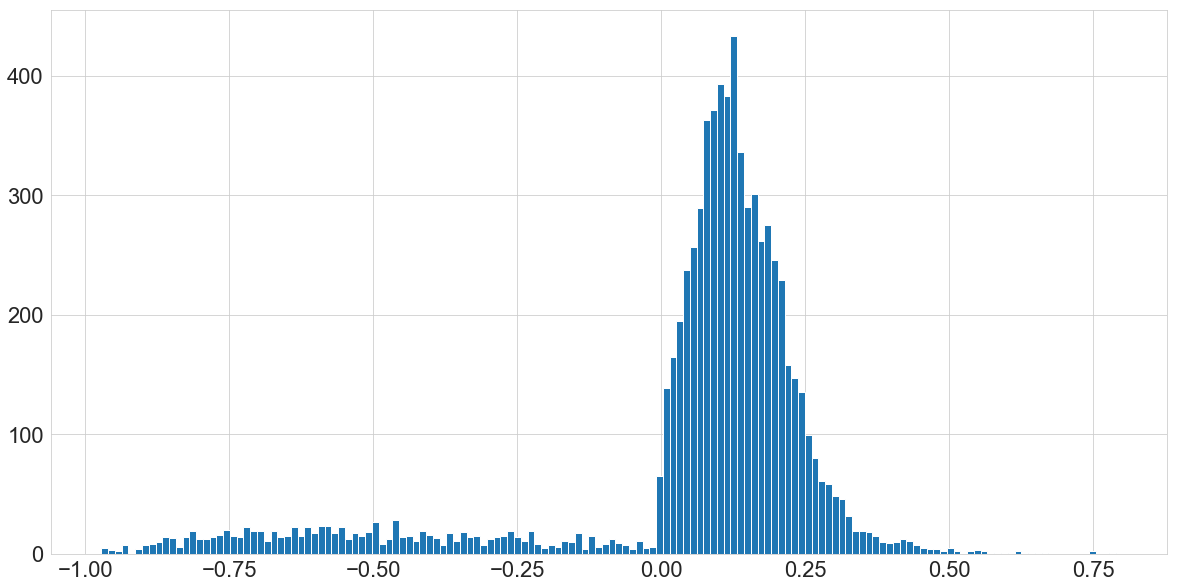


Using predictor minimal features, balanced
	Invested $99,990,800.00
	Return    4.6256%
		Number loans:  7327
		Number failed: 1184
		Interest paid:      $  15,229,798.52
		Loss of principal:  $  10,448,815.14
		Total gain:         $   4,625,203.96


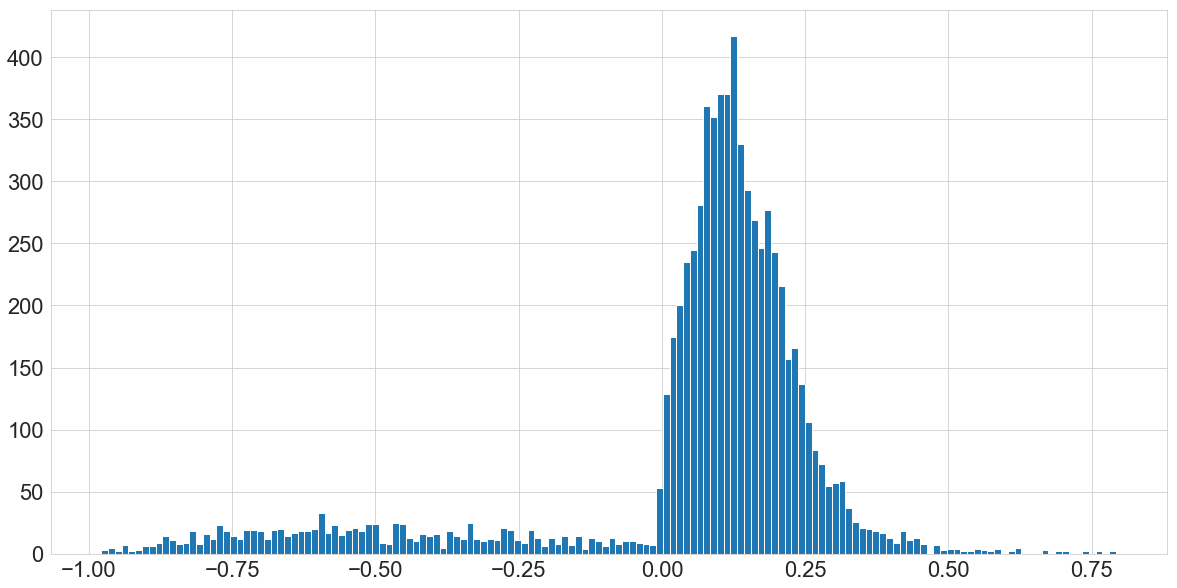

In [20]:
# Generate sample from validate set
sample_df = validate_df.sample(10000, replace=True)

# amount to invest
invest_sum = 1e8

# Evaluate results
for key, val in eval_dict.items():
    print("\nUsing predictor {}".format(key))
    
    clf       = val['clf']
    features  = val['features']
    threshold = val['threshold']
    
    # Score sampled data
    sample_df['score'] = clf.predict_proba(sample_df[features])[:,1]

    # Calculate outcomes
    invested_amnt, num_loans, num_failed, invested_loss, invested_gain, return_on_investment = \
            evaluate_invest(sample_df, invest_sum, threshold, plot=True)

    